In [7]:
import pandas as pd 
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt 
import configparser

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import shap

In [8]:
config = configparser.ConfigParser()
config.read('config.config')
fichier = config['Settings']['fichier']
ligne_debut = int(config['Settings']['ligne_debut'])
seed = int(config['Settings']['SEED'])

np.random.seed(seed)
data = pd.read_excel(fichier, skiprows=ligne_debut)


data = data.drop(['Qté facturée (Base Unit)','CA Net'], axis = 1)

data['Poids Net'] = pd.to_numeric(data['Poids Net'], errors='coerce')
data['Donneur d\'ordre'] = data['Donneur d\'ordre'].astype(str)

data = data.loc[data['Poids Net'] >0]
# Vérifier que le minimum de la colonne est supérieur ou égal à zéro
assert (data[['Poids Net']] > 0).all().all(), "Il y a des valeurs négatives dans les données d'origine"

data = data[~data['Article'].str.endswith(('-999', '-998'))]
# Vérifier qu'il ne reste pas d'articles finissant par -999 ou -998
assert (~data['Article'].str.endswith(('-999', '-998'))).all(), "Il reste des articles finissant par -999 ou -998"

data = pd.get_dummies(data, columns=['Donneur d\'ordre','Article','Mois/Année de facturation'], drop_first=True)
data.head()


,Poids Net,Donneur d'ordre_10075967,Donneur d'ordre_10076183,Donneur d'ordre_10076195,Donneur d'ordre_10076196,Donneur d'ordre_10076222,Donneur d'ordre_10076236,Donneur d'ordre_10076249,Donneur d'ordre_10076307,Donneur d'ordre_10076331,...,Article_M61309,Article_M61320,Article_M61368,Article_M80003-434,Article_M80004-434,Mois/Année de facturation_5.2023,Mois/Année de facturation_6.2023,Mois/Année de facturation_7.2023,Mois/Année de facturation_8.2023,Mois/Année de facturation_9.2023
0,856.00,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,34.40,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,19.20,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,183.18,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,184.04,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [9]:
poids_net = data['Poids Net']
boxcox_result = boxcox(poids_net)
print(boxcox_result)
boxcoced_selling_price = boxcox_result[0]
data['Poids Net'] = boxcoced_selling_price

X = data.drop(['Poids Net'], axis=1)
y = data[['Poids Net']]

print(X)
print(y)

(array([6.92573107, 3.58529847, 2.98781455, ..., 8.2467611 , 0.        ,
       4.1156129 ]), 0.007481479420234253)
       Donneur d'ordre_10075967  Donneur d'ordre_10076183  \
0                         False                     False   
1                         False                     False   
2                         False                     False   
3                         False                     False   
4                         False                     False   
...                         ...                       ...   
32931                     False                     False   
32932                     False                     False   
32933                     False                     False   
32934                     False                     False   
32935                     False                     False   

       Donneur d'ordre_10076195  Donneur d'ordre_10076196  \
0                         False                     False   
1                         Fal

In [10]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=seed)


model = LinearRegression()
#model = SVR(kernel='linear')
model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = model.predict(X_test)
print(y_pred)

[[ 1.03128052]
 [-4.72473145]
 [ 0.21554565]
 ...
 [-0.18777466]
 [ 0.01726532]
 [ 0.07080078]]


In [12]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

8.908683210545932e+27
-8.929069686533648e+27


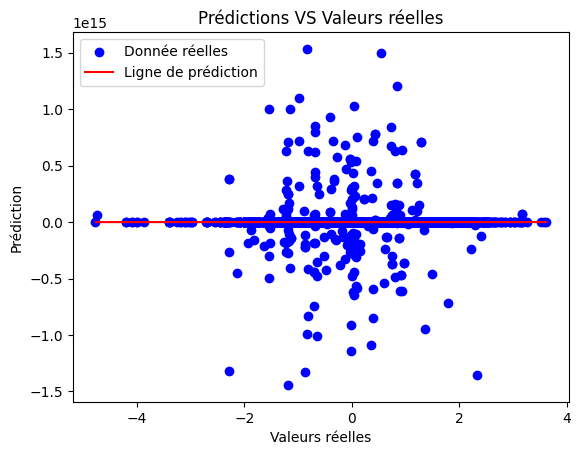

In [13]:
plt.scatter(y_test, y_pred, color='blue', label='Donnée réelles')
plt.plot(y_test, y_test, color='red', label='Ligne de prédiction')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédiction')
plt.title('Prédictions VS Valeurs réelles')
plt.legend()
plt.show()

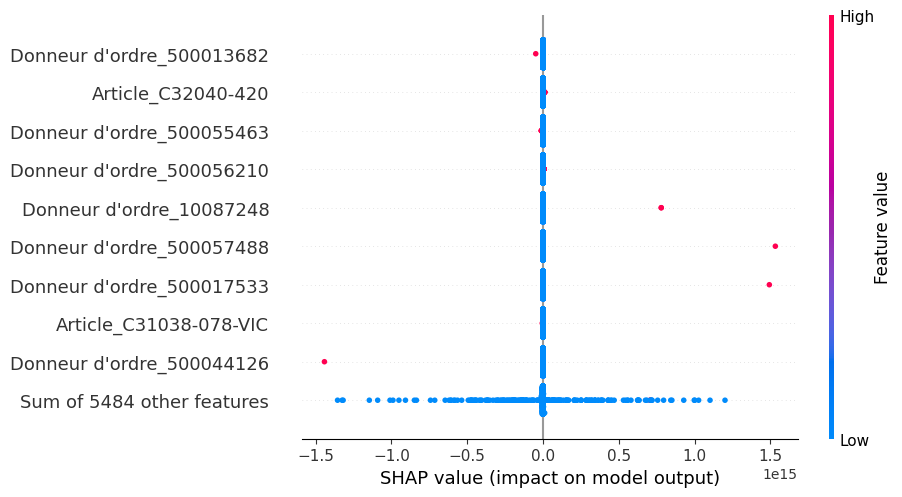

In [14]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

explainer = shap.LinearExplainer(model, X_scaled)
x_explained = explainer(X_scaled)

for key, value in enumerate(X.columns):
    x_explained.feature_names[key] = value

x_explained.data = X.values

shap.plots.beeswarm(x_explained)

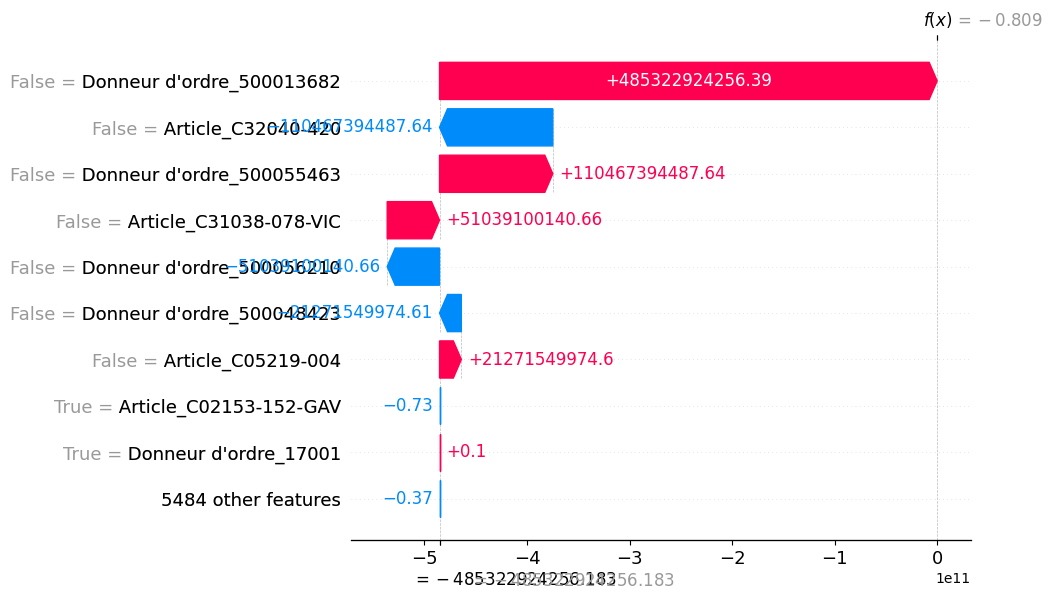

In [15]:
shap.plots.waterfall(x_explained[1])